In [ ]:
# The aim of this case study is to show an example of crop intensity change analysis based on THU global crpo intensity data accessed from FERSPAS
# The GCI collection ID on FERSPAS is "THU-GCI-INTILE". https://data.apps.fao.org/remote-sensing-portal/collections/THU-GCI-INTILE
# The country boundary used in this case study is India, the crop intensity change between 2001 and 2015 is presented.
# Created by Pengyu Hao (pengyu.hao@fao.org) on 2026/01/23.

In [23]:
from pystac_client import Client
from urllib.parse import urlparse
import glob
import gcsfs
import fiona
import rasterio
import numpy as np
import folium
from folium.raster_layers import WmsTileLayer
from rasterio.merge import merge
from rasterio.mask import mask
from rasterio.plot import show
from rasterio.enums import Resampling
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
#the link to the stac in production
API_ROOT = "https://data.apps.fao.org/geospatial/search/stac"
#using client functions to see all collections available in the STAC
client = Client.open(API_ROOT)

In [3]:
#input filters for data selection
# === EDIT THESE ===
# You can put: []  or ""  or None  to search without a collection filter.
# Or provide one or many collection ids, e.g. ["L1-UTM-NPP-D"] or "L1-UTM-NPP-D"
COLLECTIONS = "THU-GCI-INTILE"   # or [] or None
# Bounding box in WGS84 [minx, miny, maxx, maxy]; set to None to ignore
BBOX =[65, 5, 100, 40]   # for India in this case study
# Time range; set to None to ignore (STAC interval string "start/end")
#print(starttime_str)
DATETIME = "2001-01-01/2015-12-31"  # or None
# Optional: LIKE pattern for item id (SQL wildcards: % = any string, _ = single char)
# Example: "%60W.2024-12-D3%"  |  set to None to skip LIKE filtering
ITEM_ID_LIKE = None
# Optional extra STAC 'query' filter
QUERY = {
    # "eo:cloud_cover": {"lt": 20}
}
# Optional cap on results
LIMIT = 100
print("STAC_API:", API_ROOT)
print("COLLECTIONS:", COLLECTIONS)
print("BBOX:", BBOX)
print("DATETIME:", DATETIME)
print("ITEM_ID_LIKE:", ITEM_ID_LIKE)

STAC_API: https://data.apps.fao.org/geospatial/search/stac
COLLECTIONS: THU-GCI-INTILE
BBOX: [65, 5, 100, 40]
DATETIME: 2001-01-01/2015-12-31
ITEM_ID_LIKE: None


In [4]:
#functions to select items from collection
def _normalize_collections(val):
    if val is None:
        return None
    if isinstance(val, str):
        val = val.strip()
        return [val] if val else None
    if isinstance(val, (list, tuple)):
        vals = [v for v in (x.strip() for x in val) if v]
        return vals or None
    return None

search_kwargs = dict(
    collections=_normalize_collections(COLLECTIONS),
    bbox=BBOX or None,
    datetime=DATETIME or None,
    query=QUERY or None,
    limit=LIMIT,
)

#get and show the list of the selected items of the recent 15 day.
# Add LIKE filter only if user provided ITEM_ID_LIKE
if ITEM_ID_LIKE:
    search_kwargs.update({
        "filter_lang": "cql2-json",
        "filter": {
            "op": "like",
            "args": [
                {"property": "id"},
                ITEM_ID_LIKE
            ]
        }
    })

search = client.search(**search_kwargs)
items = list(search.items())
for item in items:
    print(item.id)
#print(len(items))

THU.THU-GCI-INTILE.60E90N.2015
THU.THU-GCI-INTILE.60E90N.2014
THU.THU-GCI-INTILE.60E90N.2013
THU.THU-GCI-INTILE.60E90N.2012
THU.THU-GCI-INTILE.60E90N.2011
THU.THU-GCI-INTILE.60E90N.2010
THU.THU-GCI-INTILE.60E90N.2009
THU.THU-GCI-INTILE.60E90N.2008
THU.THU-GCI-INTILE.60E90N.2007
THU.THU-GCI-INTILE.60E90N.2006
THU.THU-GCI-INTILE.60E90N.2005
THU.THU-GCI-INTILE.60E90N.2004
THU.THU-GCI-INTILE.60E90N.2003
THU.THU-GCI-INTILE.60E90N.2002
THU.THU-GCI-INTILE.60E90N.2001
THU.THU-GCI-INTILE.60E30N.2015
THU.THU-GCI-INTILE.60E30N.2014
THU.THU-GCI-INTILE.60E30N.2013
THU.THU-GCI-INTILE.60E30N.2012
THU.THU-GCI-INTILE.60E30N.2011
THU.THU-GCI-INTILE.60E30N.2010
THU.THU-GCI-INTILE.60E30N.2009
THU.THU-GCI-INTILE.60E30N.2008
THU.THU-GCI-INTILE.60E30N.2007
THU.THU-GCI-INTILE.60E30N.2006
THU.THU-GCI-INTILE.60E30N.2005
THU.THU-GCI-INTILE.60E30N.2004
THU.THU-GCI-INTILE.60E30N.2003
THU.THU-GCI-INTILE.60E30N.2002
THU.THU-GCI-INTILE.60E30N.2001


In [5]:
# download selected items
PREVIEW_SCALE = 16                 # 8 = sharper, 16 = faster, 32 = fastest
DOWNLOAD_CHUNK = 8 * 1024 * 1024   # 8MB streaming chunks
def _is_geotiff(a):
    mt = (a.media_type or "").lower()
    href = (a.href or "").lower()
    return ("image/tiff" in mt) or href.endswith((".tif", ".tiff"))

# pick asset
def pick_asset(it):
    preferred = ("data", "visual", "rendered_preview", "B04", "B03", "B02", "nir")
    for k in preferred:
        if k in it.assets and _is_geotiff(it.assets[k]):
            return it.assets[k], k
    for k, a in it.assets.items():
        if _is_geotiff(a):
            return a, k
    return None, None
    
# function to normalize the gs path
def normalize_to_gs(href: str) -> str:
    if not href:
        return href
    if href.startswith("gs://"):
        return href

    if "storage.cloud.google.com" in href:
        p = urlparse(href)
        path = p.path.lstrip("/")  # bucket/object
        return f"gs://{path}"

    if "storage.googleapis.com" in href:
        p = urlparse(href)
        parts = p.path.lstrip("/").split("/", 1)
        if len(parts) == 2:
            bucket, obj = parts
            return f"gs://{bucket}/{obj}"
    return href
#function to download data to compute engine
def download_gcs_to_temp(gs_uri: str, local_path) -> str:
    if not gs_uri.startswith("gs://"):
        return gs_uri
    fs = gcsfs.GCSFileSystem()
    bucket_and_key = gs_uri[5:]
    #tmp = tempfile.NamedTemporaryFile(suffix=".tif", delete=False)
    #local_path = tmp.name
    #local_path = "/RSP_test/ASIS_test/GS1LCC/Global/"+"x.tif"
    print(f"Downloading (streamed) {gs_uri}")
    with fs.open(bucket_and_key, "rb") as src, open(local_path, "wb") as dst:
        while True:
            chunk = src.read(DOWNLOAD_CHUNK)
            if not chunk:
                break
            dst.write(chunk)
    return local_path

#download script
#local path base
Path_base = "/home/pengyu_hao_fao_org/"
Path_folder = "RSP_test/GCI_test/raw/"
#print(item.id)
for item in items:
    Path_local = Path_base + Path_folder + item.id + ".tif"
    asset, asset_key = pick_asset(item)
    if not asset:
        raise RuntimeError(f"No GeoTIFF/COG asset found for item {item.id}")
    href = asset.href or asset.get_absolute_href()
    if not href:
        raise RuntimeError(f"Asset '{asset_key}' has no usable href.")
    print(href)
    gs_uri = normalize_to_gs(href)
    #download the item to Path_local
    download_gcs_to_temp(gs_uri, Path_local)
    print(Path_local)

https://storage.googleapis.com/fao-gismgr-thu-data/DATA/THU/MOSAICSET/THU-GCI-INTILE/THU.THU-GCI-INTILE.60E90N.2015.tif
/home/pengyu_hao_fao_org/RSP_test/GCI_test/raw/THU.THU-GCI-INTILE.60E90N.2015.tif
https://storage.googleapis.com/fao-gismgr-thu-data/DATA/THU/MOSAICSET/THU-GCI-INTILE/THU.THU-GCI-INTILE.60E90N.2014.tif
/home/pengyu_hao_fao_org/RSP_test/GCI_test/raw/THU.THU-GCI-INTILE.60E90N.2014.tif
https://storage.googleapis.com/fao-gismgr-thu-data/DATA/THU/MOSAICSET/THU-GCI-INTILE/THU.THU-GCI-INTILE.60E90N.2013.tif
/home/pengyu_hao_fao_org/RSP_test/GCI_test/raw/THU.THU-GCI-INTILE.60E90N.2013.tif
https://storage.googleapis.com/fao-gismgr-thu-data/DATA/THU/MOSAICSET/THU-GCI-INTILE/THU.THU-GCI-INTILE.60E90N.2012.tif
/home/pengyu_hao_fao_org/RSP_test/GCI_test/raw/THU.THU-GCI-INTILE.60E90N.2012.tif
https://storage.googleapis.com/fao-gismgr-thu-data/DATA/THU/MOSAICSET/THU-GCI-INTILE/THU.THU-GCI-INTILE.60E90N.2011.tif
/home/pengyu_hao_fao_org/RSP_test/GCI_test/raw/THU.THU-GCI-INTILE.60E90N

In [6]:
# get all feilds and get all time phases
#get all the datasets from the data path
path_raw = "/home/pengyu_hao_fao_org/RSP_test/GCI_test/raw/"
datalist = glob.glob(path_raw + "*.tif")
datalist.sort()
#print(datalist)
#get all time phases from the data list
timephase = []
for item in datalist:
    #print(item)
    index = item.find(".tif")
    time = item[index-4:index]
    if time in timephase:
        continue
    timephase.append(time)
print(timephase)    

['2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015']


In [28]:
# define a function to find element in a list of string
def target_sublist(datalist, target):
    list_select = []
    #target = '2024-01-D1'
    for tmp in datalist:
        if target in tmp:
            list_select.append(tmp)
    return list_select

# mosaic the data of each time phase and output
path_mosaic = "/home/pengyu_hao_fao_org/RSP_test/GCI_test/mosaic/"
for time in timephase:
    sublist = target_sublist(datalist, time)
    print(sublist)
    file_mosaic = path_mosaic + "THU-GCI-" + time + ".tif"
    print(file_mosaic)

    srcs = [rasterio.open(fp) for fp in sublist]
    mosaic, transform = merge(srcs)
    meta = srcs[0].meta.copy()
    meta.update({
        "driver": "COG",
        "height": mosaic.shape[1],
        "width": mosaic.shape[2],
        "transform": transform,
        "tiled": True,
        'blocksize': 512,
        "compress": "deflate"
    })
    with rasterio.open(file_mosaic, "w", **meta) as dst:
        dst.write(mosaic)
    
    for src in srcs:
        src.close()

['/home/pengyu_hao_fao_org/RSP_test/GCI_test/raw/THU.THU-GCI-INTILE.60E30N.2001.tif', '/home/pengyu_hao_fao_org/RSP_test/GCI_test/raw/THU.THU-GCI-INTILE.60E90N.2001.tif']
/home/pengyu_hao_fao_org/RSP_test/GCI_test/mosaic/THU-GCI-2001.tif
['/home/pengyu_hao_fao_org/RSP_test/GCI_test/raw/THU.THU-GCI-INTILE.60E30N.2002.tif', '/home/pengyu_hao_fao_org/RSP_test/GCI_test/raw/THU.THU-GCI-INTILE.60E90N.2002.tif']
/home/pengyu_hao_fao_org/RSP_test/GCI_test/mosaic/THU-GCI-2002.tif
['/home/pengyu_hao_fao_org/RSP_test/GCI_test/raw/THU.THU-GCI-INTILE.60E30N.2003.tif', '/home/pengyu_hao_fao_org/RSP_test/GCI_test/raw/THU.THU-GCI-INTILE.60E90N.2003.tif']
/home/pengyu_hao_fao_org/RSP_test/GCI_test/mosaic/THU-GCI-2003.tif
['/home/pengyu_hao_fao_org/RSP_test/GCI_test/raw/THU.THU-GCI-INTILE.60E30N.2004.tif', '/home/pengyu_hao_fao_org/RSP_test/GCI_test/raw/THU.THU-GCI-INTILE.60E90N.2004.tif']
/home/pengyu_hao_fao_org/RSP_test/GCI_test/mosaic/THU-GCI-2004.tif
['/home/pengyu_hao_fao_org/RSP_test/GCI_test/raw

In [9]:
# get all files from the mosaic path
mosaic_files = glob.glob(path_mosaic + "*.tif")
mosaic_files.sort()
#value for no data
nodata = 128
#clip all the files with India boundary
shp_file = "/home/pengyu_hao_fao_org/Boundary/Global/shp/Global.shp"
folder_clip = "/home/pengyu_hao_fao_org/" + "RSP_test/GCI_test/clip/"
shp = fiona.open(shp_file)
#print(shp)
# The attribute and value you are looking for
attribute_name = 'ISO3CD'
attribute_value = 'IND'
# Open the shapefile, and get the geometry of the selected feature
# with fiona.open(shapefile_path) as shapefile:
for feature in shp:
    # Check if the attribute matches the desired value
    if feature['properties'][attribute_name] == attribute_value:
        geom = feature['geometry']
        break
print(geom)

# Using India boundary to clip the the mosaic image, label th nodata value as 128, save as cog
for file in mosaic_files:
    #print(file)
    index_start = file.rfind("/")
    index_end = file.find(".tif")
    tmp_name = file[index_start+1:index_end]
    print(tmp_name)
    file_out = folder_clip + tmp_name + "-IND.tif"
    print(file_out)
    raster_tmp = rasterio.open(file)
    out_tmp_image, out_transform = mask(raster_tmp,[geom],crop=True,nodata=nodata)

    out_meta = raster_tmp.meta.copy()
    out_meta.update({
        'driver':"COG",
        'height': out_tmp_image.shape[1],
        'width': out_tmp_image.shape[2],
        'transform': out_transform,
        'blocksize': 512,
        'compress': "deflate",
        'nodata': nodata
    })

    with rasterio.open(file_out, 'w', **out_meta) as dest:
        dest.write(out_tmp_image)
    

fiona.Geometry(coordinates=[[[(76.51896677400003, 33.17082724900007), ...], ...], ...], type='MultiPolygon')
THU-GCI-2001
/home/pengyu_hao_fao_org/RSP_test/GCI_test/clip/THU-GCI-2001-IND.tif
THU-GCI-2002
/home/pengyu_hao_fao_org/RSP_test/GCI_test/clip/THU-GCI-2002-IND.tif
THU-GCI-2003
/home/pengyu_hao_fao_org/RSP_test/GCI_test/clip/THU-GCI-2003-IND.tif
THU-GCI-2004
/home/pengyu_hao_fao_org/RSP_test/GCI_test/clip/THU-GCI-2004-IND.tif
THU-GCI-2005
/home/pengyu_hao_fao_org/RSP_test/GCI_test/clip/THU-GCI-2005-IND.tif
THU-GCI-2006
/home/pengyu_hao_fao_org/RSP_test/GCI_test/clip/THU-GCI-2006-IND.tif
THU-GCI-2007
/home/pengyu_hao_fao_org/RSP_test/GCI_test/clip/THU-GCI-2007-IND.tif
THU-GCI-2008
/home/pengyu_hao_fao_org/RSP_test/GCI_test/clip/THU-GCI-2008-IND.tif
THU-GCI-2009
/home/pengyu_hao_fao_org/RSP_test/GCI_test/clip/THU-GCI-2009-IND.tif
THU-GCI-2010
/home/pengyu_hao_fao_org/RSP_test/GCI_test/clip/THU-GCI-2010-IND.tif
THU-GCI-2011
/home/pengyu_hao_fao_org/RSP_test/GCI_test/clip/THU-GCI-20

In [18]:
# crop intensity analysis
file_dy = "/home/pengyu_hao_fao_org/RSP_test/GCI_test/dy/GCI_change.tif"
clip_files = glob.glob(folder_clip + '*.tif')
clip_files.sort()
CI_IND_2001 = clip_files[0]
CI_IND_2015 = clip_files[14]

# read images with nodata mask
with rasterio.open(CI_IND_2001) as src:
    data_2001 = src.read(1, masked=True)
    profile = src.profile.copy()

with rasterio.open(CI_IND_2015) as src:
    data_2015 = src.read(1, masked=True)
    profile = src.profile.copy()
    
# crop intensity change computation, save as cog with pyramid
data_out = data_2015 - data_2001
#data_out = out.astype("float32")
#print(np.shape(data_out))
profile.update(
    driver="COG",
    dtype="int8",
    nodata=None,          # use mask instead
    compress="deflate",
    predictor=2,
    blocksize=512,
    overview_resampling=Resampling.average,
)
with rasterio.open(file_dy, "w", **profile) as dst:
    dst.write(data_out.data, 1)
    dst.write_mask((~data_out.mask).astype("uint8") * 255)

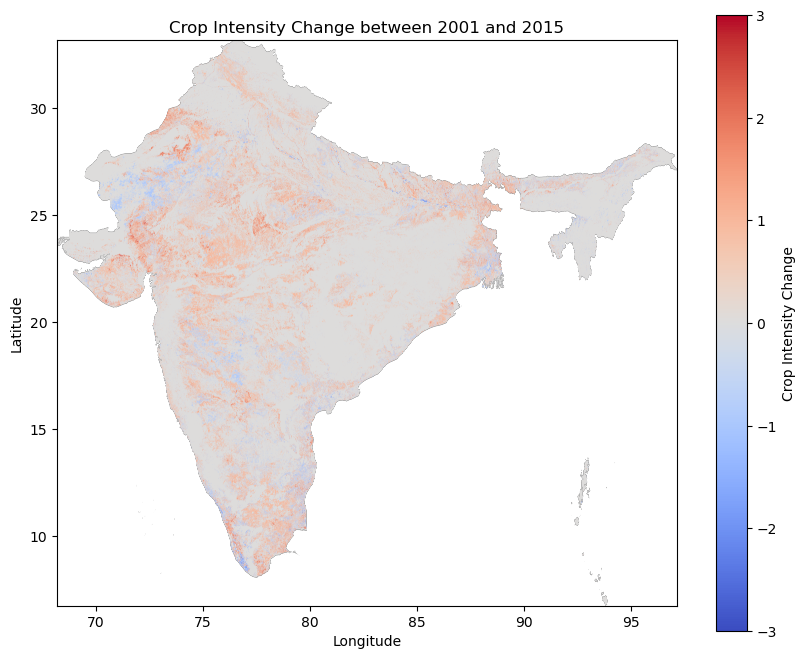

In [27]:
# read the crop intensity change image
with rasterio.open(file_dy) as src:
    data = src.read(1, masked=True)
    bounds = src.bounds  # geographic extent

plt.figure(figsize=(10, 8))
plt.imshow(
    data,
    extent=[bounds.left, bounds.right, bounds.bottom, bounds.top],
    cmap="coolwarm",     # blue → red
    origin="upper"
)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.colorbar(label="Crop Intensity Change")
plt.title("Crop Intensity Change between 2001 and 2015")
plt.show()